<a href="https://colab.research.google.com/github/Ashkar077/INT345-CV-MULTILABELIMAGECLASSIFICATION/blob/main/MultiLevelRecovered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d temesgentewolde/animal-dataset-intermediate

100% 215M/216M [00:09<00:00, 33.2MB/s]
100% 216M/216M [00:09<00:00, 23.4MB/s]


In [6]:
! unzip animal-dataset-intermediate.zip

Streaming output truncated to the last 5000 lines.
  inflating: animal_dataset_intermediate/train/farfalla/ee31b20a2cfd1c22d2524518b7444f92e37fe5d404b0144390f8c770a3e5b7_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla/ee36b10b2bf41c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla/ee36b5092df01c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla/ef31b30f2de90021d85a5854ee454296eb70e3c818b413449df6c87fa7ee_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla/ef34b00e2ef31c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla/ef3db70e29f31c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg  
  inflating: animal_dataset_intermediate/train/mucca/OIP---lAIbDlHKmejDpqrXq6vAAAAA.jpeg  
  inflating: animal_dataset_intermediate/train/mucca/OIP--8_E2EnxrYh7eym5nYRTJQHaE7.jp

In [7]:
import os
base_dir = '/content/animal_dataset_intermediate'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [8]:
print("Training images:")
for i in os.listdir(train_dir):
    print(f"----{i.split('_')[0]}: {len(os.listdir(os.path.join(train_dir, i)))} images.")

Training images:
----scoiattolo: 1676 images.
----mucca: 1680 images.
----elefante: 1299 images.
----farfalla: 1867 images.
----pecora: 1638 images.


In [9]:
print(f"Testing images: {len(os.listdir(test_dir))}")

Testing images: 910


In [10]:
def load_img(path_to_img):
    # max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    # scale = max_dim / long_dim
    scale = 1

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

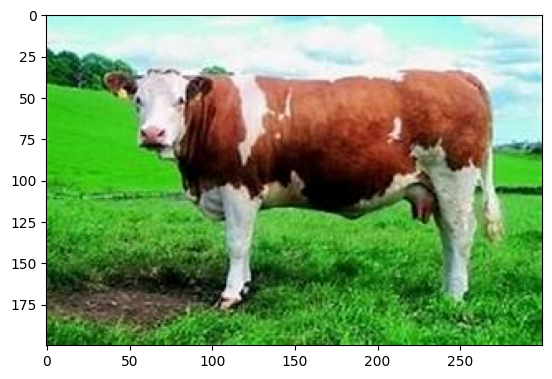

In [12]:
import tensorflow as tf
from matplotlib import pyplot as plt
img = load_img(os.path.join(test_dir, os.listdir(test_dir)[0]))
imshow(img)

In [13]:
batch_size = 128
IMG_SHAPE = 160

In [14]:
from keras.preprocessing.image import ImageDataGenerator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     horizontal_flip=True,
                                     rotation_range=15,
                                     zoom_range=0.1,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.1,
                                     fill_mode='nearest',
                                     validation_split=0.2)


train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='sparse',
                                                     seed=42,
                                                     subset='training')

image_gen_val = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                   directory=train_dir,
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE, IMG_SHAPE),
                                                   class_mode='sparse',
                                                   seed=42,
                                                   subset='validation')

Found 6530 images belonging to 5 classes.
Found 1630 images belonging to 5 classes.


In [15]:
class_names = train_data_gen.class_indices
class_names = [k.split('_')[0] for k in class_names]
class_names

['elefante', 'farfalla', 'mucca', 'pecora', 'scoiattolo']

In [16]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

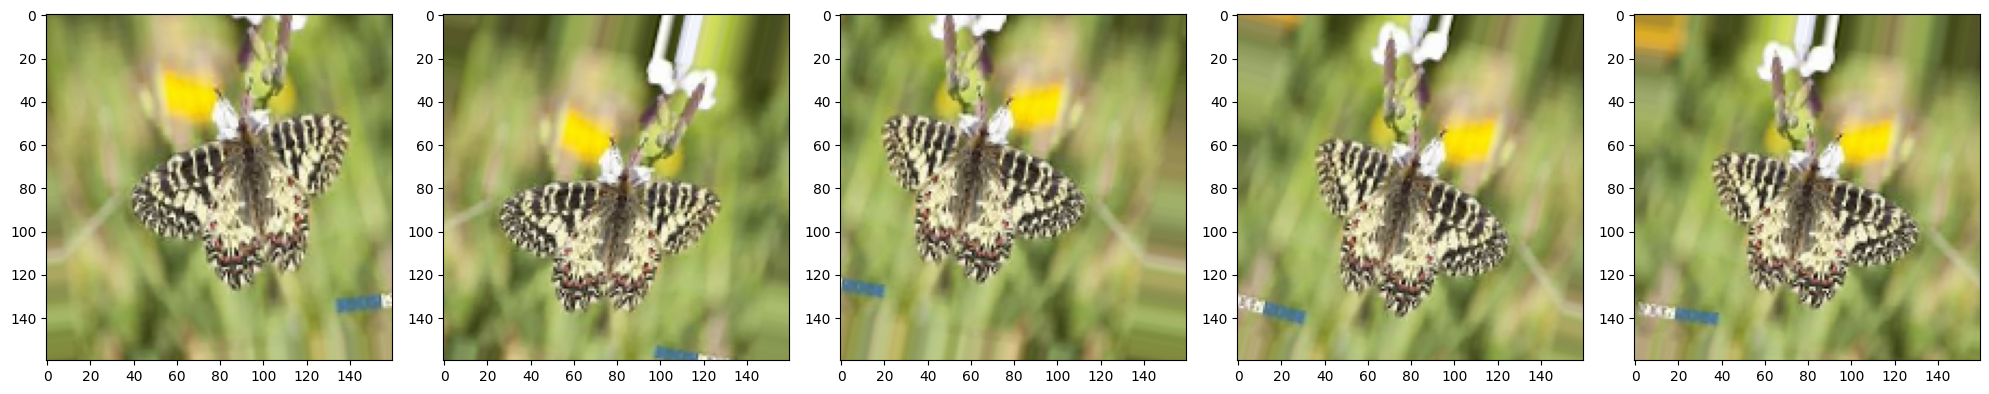

In [17]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

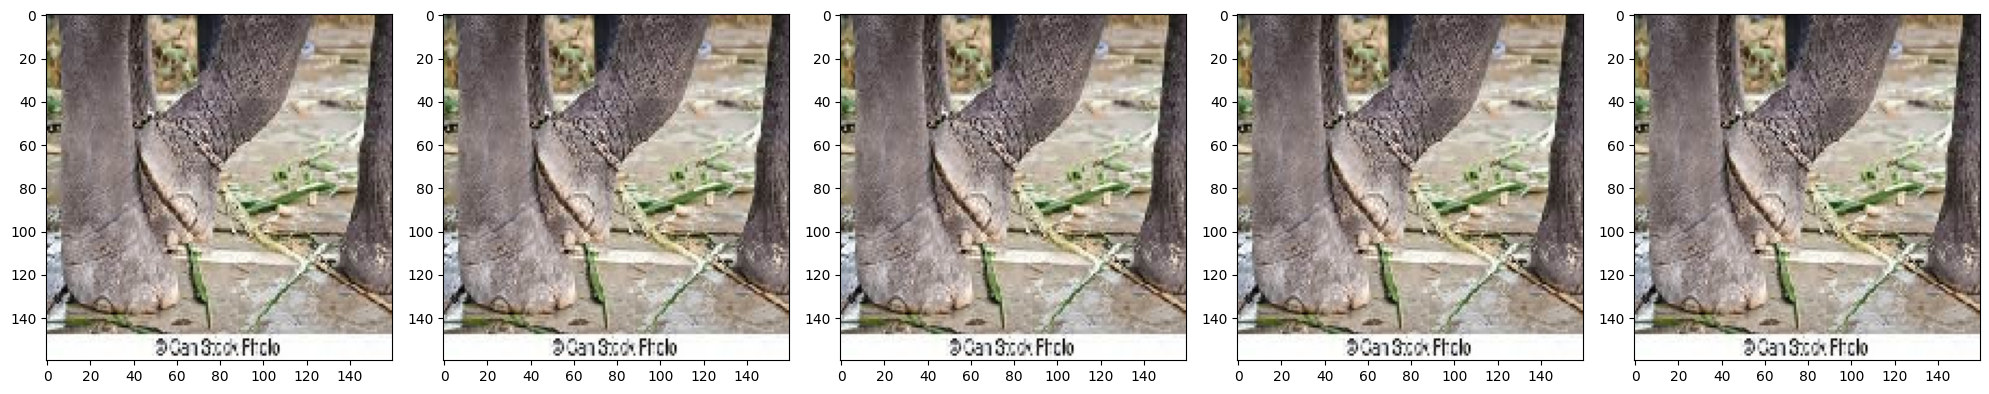

In [18]:
augmented_images_val = [val_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images_val)

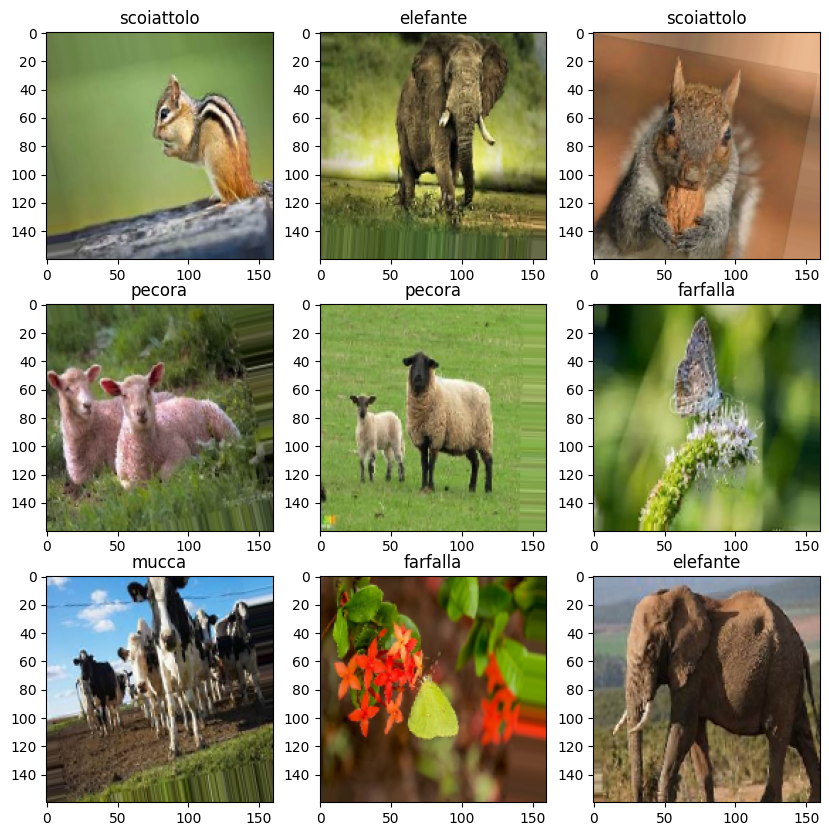

In [19]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_data_gen:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = tf.keras.preprocessing.image.array_to_img(image_batch[i])
        plt.imshow(img)
        plt.title(class_names[int(labels_batch[i])])
    break

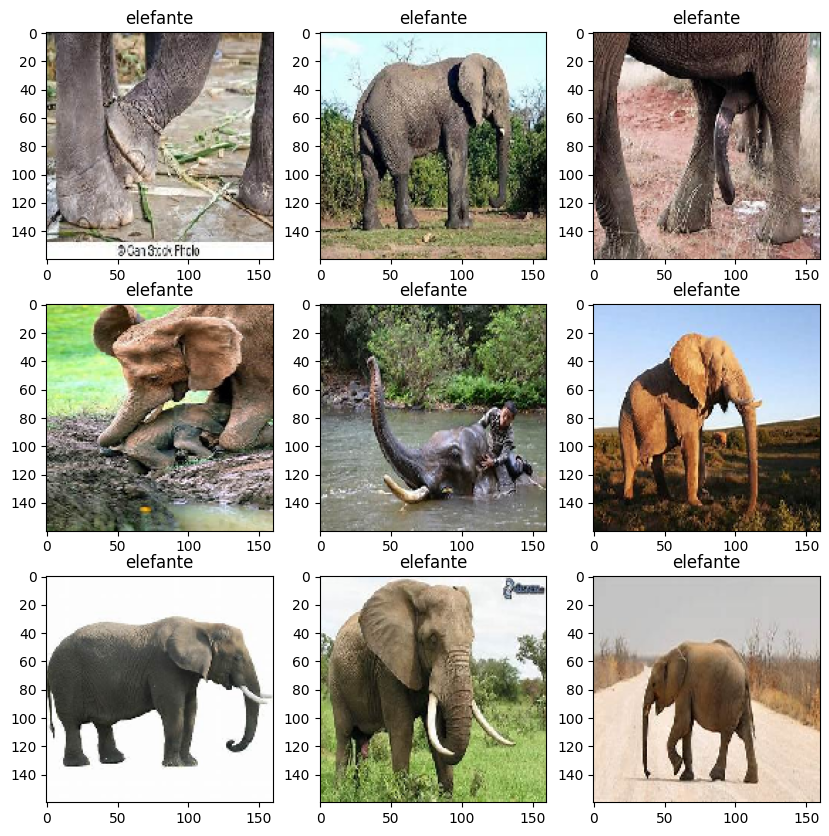

In [20]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in val_data_gen:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = tf.keras.preprocessing.image.array_to_img(image_batch[i])
        plt.imshow(img)
        plt.title(class_names[int(labels_batch[i])])
    break

In [21]:
model_mlp = tf.keras.models.Sequential([
        tf.keras.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dense(5, activation='softmax')
])

In [22]:
model_mlp = tf.keras.models.Sequential([
    tf.keras.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [23]:
initial_learning_rate = 1e-2

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [24]:
model_mlp.compile(optimizer=optimizer,
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [25]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, verbose=1, patience=10)

In [27]:
epochs = 10

history_mlp = model_mlp.fit(
    train_data_gen,
    steps_per_epoch = train_data_gen.n // batch_size,
    validation_data = val_data_gen,
    validation_steps = val_data_gen.n // batch_size,
    epochs=epochs,
    callbacks=[tensorboard_callback, es])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


51/51 [==============================] - 53s 828ms/step - loss: 1.5848 - accuracy: 0.2602 - val_loss: 1.5411 - val_accuracy: 0.3190
Epoch 2/10
51/51 [==============================] - 44s 856ms/step - loss: 1.5609 - accuracy: 0.2921 - val_loss: 1.5068 - val_accuracy: 0.3431
Epoch 3/10
51/51 [==============================] - 43s 847ms/step - loss: 1.5267 - accuracy: 0.3255 - val_loss: 1.4538 - val_accuracy: 0.3835
Epoch 4/10
51/51 [==============================] - 42s 822ms/step - loss: 1.4758 - accuracy: 0.3664 - val_loss: 1.3742 - val_accuracy: 0.4427
Epoch 5/10
51/51 [==============================] - 42s 820ms/step - loss: 1.4252 - accuracy: 0.4000 - val_loss: 1.3305 - val_accuracy: 0.4622
Epoch 6/10
51/51 [==============================] - 41s 805ms/step - loss: 1.4040 - accuracy: 0.4311 - val_loss: 1.2592 - val_accuracy: 0.5111
Epoch 7/10
51/51 [==============================] - 41s 807ms/step - loss: 1.3313 - accuracy: 0.4570 - val_loss: 1.1930 - val_accuracy: 0.5299
Epoch 8/10

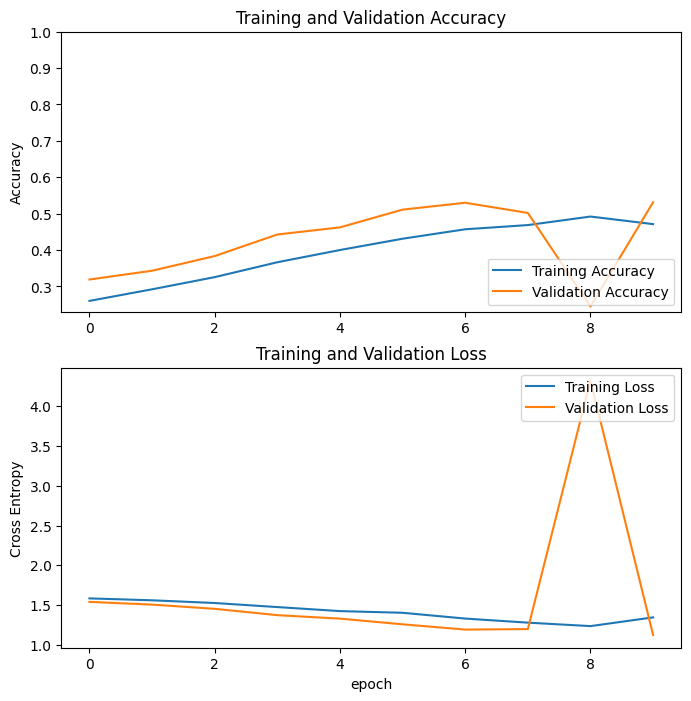

In [28]:
acc = history_mlp.history['accuracy']
val_acc = history_mlp.history['val_accuracy']

loss = history_mlp.history['loss']
val_loss = history_mlp.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])


In [30]:
#Adaptive Moment Estimaton
optimizer = tf.keras.optimizers.Adam()

In [31]:
model_cnn.compile(optimizer=optimizer,
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='max', factor=0.1, patience=5, min_lr=1e-6, verbose=1)

In [33]:
log_dir_cnn = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [34]:
epochs = 10

history_cnn = model_cnn.fit(
    train_data_gen,
    steps_per_epoch = train_data_gen.n // batch_size,
    validation_data = val_data_gen,
    validation_steps = val_data_gen.n // batch_size,
    epochs=epochs,
    callbacks=[tensorboard_callback, reduce_lr, es])

Epoch 1/10
51/51 [==============================] - 43s 787ms/step - loss: 2.2394 - accuracy: 0.2901 - val_loss: 1.8224 - val_accuracy: 0.2845 - lr: 0.0010
Epoch 2/10
51/51 [==============================] - 42s 817ms/step - loss: 1.6825 - accuracy: 0.3582 - val_loss: 1.6442 - val_accuracy: 0.3958 - lr: 0.0010
Epoch 3/10
51/51 [==============================] - 41s 808ms/step - loss: 1.4991 - accuracy: 0.4103 - val_loss: 1.6089 - val_accuracy: 0.4258 - lr: 0.0010
Epoch 4/10
51/51 [==============================] - 41s 797ms/step - loss: 1.4640 - accuracy: 0.4514 - val_loss: 1.4323 - val_accuracy: 0.4655 - lr: 0.0010
Epoch 5/10
51/51 [==============================] - 41s 808ms/step - loss: 1.3352 - accuracy: 0.4966 - val_loss: 1.2550 - val_accuracy: 0.5371 - lr: 0.0010
Epoch 6/10
51/51 [==============================] - ETA: 0s - loss: 1.2646 - accuracy: 0.5542
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
51/51 [==============================] - 41s 806m

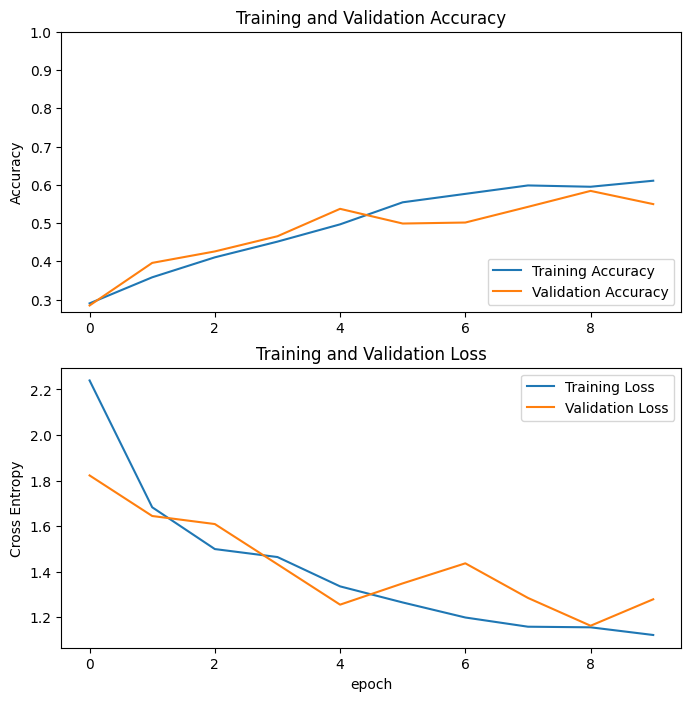

In [35]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
import pandas as pd
test_data = pd.read_csv(base_dir + "/Testing_set_animals.csv")
len(test_data)

910

In [37]:
for i in range(len(test_data)):
    img_name = test_data.filename[i]
    img_path = os.path.join(test_dir, img_name)
    image = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SHAPE, IMG_SHAPE))
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array /= 255.0
    img_array = tf.expand_dims(img_array, 0)
    prediction = model_mlp.predict(img_array)
    test_data.target[i] = class_names[prediction.argmax()]
test_data.head()

1/1 [==============================] - 0s 16ms/step


<ipython-input-37-4c6616fc5acc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.target[i] = class_names[prediction.argmax()]


1/1 [==============================] - 0s 16ms/step


filename    target
0  e030b20928e90021d85a5854ee454296eb70e3c818b413...  farfalla
1  e030b20929e90021d85a5854ee454296eb70e3c818b413...  farfalla
2  e030b2092be90021d85a5854ee454296eb70e3c818b413...  farfalla
3  e030b2092ce90021d85a5854ee454296eb70e3c818b413...  farfalla
4  e030b2092de90021d85a5854ee454296eb70e3c818b413...  farfalla

In [38]:
!mkdir results
test_data.to_csv('results/result_mlp.csv')

In [39]:
for i in range(len(test_data)):
    img_name = test_data.filename[i]
    img_path = os.path.join(test_dir, img_name)
    image = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SHAPE, IMG_SHAPE))
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array /= 255.0
    img_array = tf.expand_dims(img_array, 0)
    prediction = model_cnn.predict(img_array)
    test_data.target[i] = class_names[prediction.argmax()]
test_data.head()

1/1 [==============================] - 0s 16ms/step


filename    target
0  e030b20928e90021d85a5854ee454296eb70e3c818b413...  farfalla
1  e030b20929e90021d85a5854ee454296eb70e3c818b413...  farfalla
2  e030b2092be90021d85a5854ee454296eb70e3c818b413...  farfalla
3  e030b2092ce90021d85a5854ee454296eb70e3c818b413...  farfalla
4  e030b2092de90021d85a5854ee454296eb70e3c818b413...  farfalla

In [40]:
test_data.to_csv('results/result_cnn.csv')

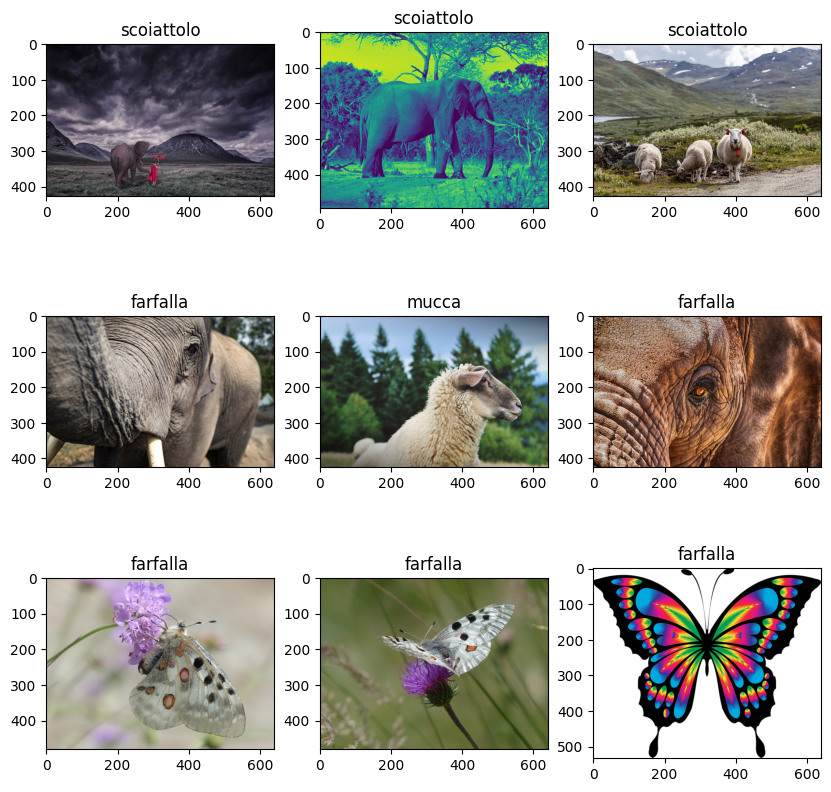

In [41]:
import PIL.Image as Image
plt.figure(figsize=(10, 10))
for i in range(9):
    img_name = test_data.filename[i+200]
    img_path = os.path.join(test_dir, img_name)
    label = test_data.target[i+200]
    ax = plt.subplot(3, 3, i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(label)

Text(0.5, 1.0, 'farfalla')

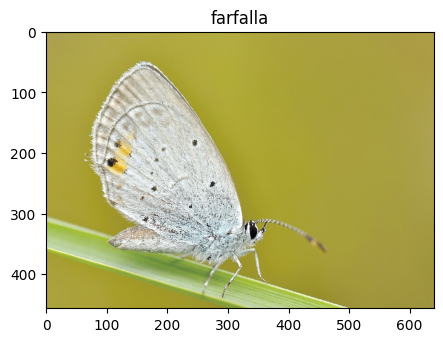

In [42]:
import PIL.Image as Image

# Choose a specific index to target
index_to_display = 1  # Adjust this index to your desired image

plt.figure(figsize=(5, 5))  # Adjust figure size as needed

img_name = test_data.filename[index_to_display]
img_path = os.path.join(test_dir, img_name)
label = test_data.target[index_to_display]

img = Image.open(img_path)
plt.imshow(img)
plt.title(label)

In [43]:
INPUT_SHAPE = (IMG_SHAPE, IMG_SHAPE) + (3,)

In [44]:
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [45]:
image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 5, 5, 1280)


In [46]:
#The weights of the layers in the base_model will not be updated.
base_model.trainable = False

In [47]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)

In [48]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
transfer_model = tf.keras.Model(inputs, outputs)

In [49]:
base_learning_rate = 0.0001
transfer_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [50]:
initial_epochs = 10

history_transfer = transfer_model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=val_data_gen)

Epoch 1/10
52/52 [==============================] - 44s 800ms/step - loss: 1.6044 - accuracy: 0.3481 - val_loss: 1.1360 - val_accuracy: 0.5810
Epoch 2/10
52/52 [==============================] - 41s 783ms/step - loss: 1.0731 - accuracy: 0.5963 - val_loss: 0.7650 - val_accuracy: 0.7742
Epoch 3/10
52/52 [==============================] - 40s 774ms/step - loss: 0.7716 - accuracy: 0.7444 - val_loss: 0.5664 - val_accuracy: 0.8454
Epoch 4/10
52/52 [==============================] - 41s 783ms/step - loss: 0.6129 - accuracy: 0.8049 - val_loss: 0.4469 - val_accuracy: 0.8853
Epoch 5/10
52/52 [==============================] - 41s 781ms/step - loss: 0.5060 - accuracy: 0.8449 - val_loss: 0.3781 - val_accuracy: 0.8994
Epoch 6/10
52/52 [==============================] - 41s 788ms/step - loss: 0.4387 - accuracy: 0.8640 - val_loss: 0.3332 - val_accuracy: 0.9080
Epoch 7/10
52/52 [==============================] - 40s 770ms/step - loss: 0.4009 - accuracy: 0.8761 - val_loss: 0.3005 - val_accuracy: 0.9172

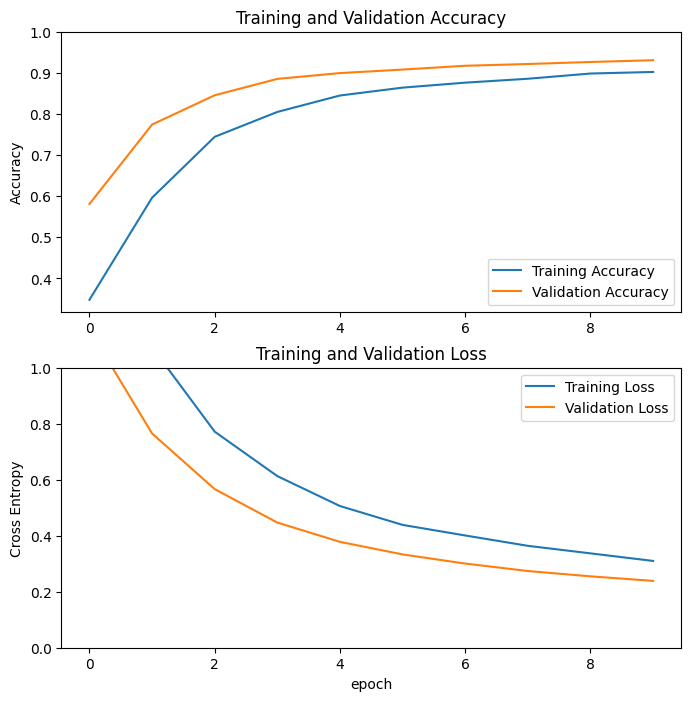

In [51]:
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [52]:
transfer_model.save('models/transfer_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
for i in range(len(test_data)):
    img_name = test_data.filename[i]
    img_path = os.path.join(test_dir, img_name)
    image = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SHAPE, IMG_SHAPE))
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array /= 255.0
    img_array = tf.expand_dims(img_array, 0)
    prediction = transfer_model.predict(img_array)
    test_data.target[i] = class_names[prediction.argmax()]

1/1 [==============================] - 0s 19ms/step


In [54]:
test_data.head()

filename    target
0  e030b20928e90021d85a5854ee454296eb70e3c818b413...  farfalla
1  e030b20929e90021d85a5854ee454296eb70e3c818b413...  farfalla
2  e030b2092be90021d85a5854ee454296eb70e3c818b413...  farfalla
3  e030b2092ce90021d85a5854ee454296eb70e3c818b413...  farfalla
4  e030b2092de90021d85a5854ee454296eb70e3c818b413...  farfalla

In [55]:
test_data.to_csv("results/result_transfer.csv", index=False)

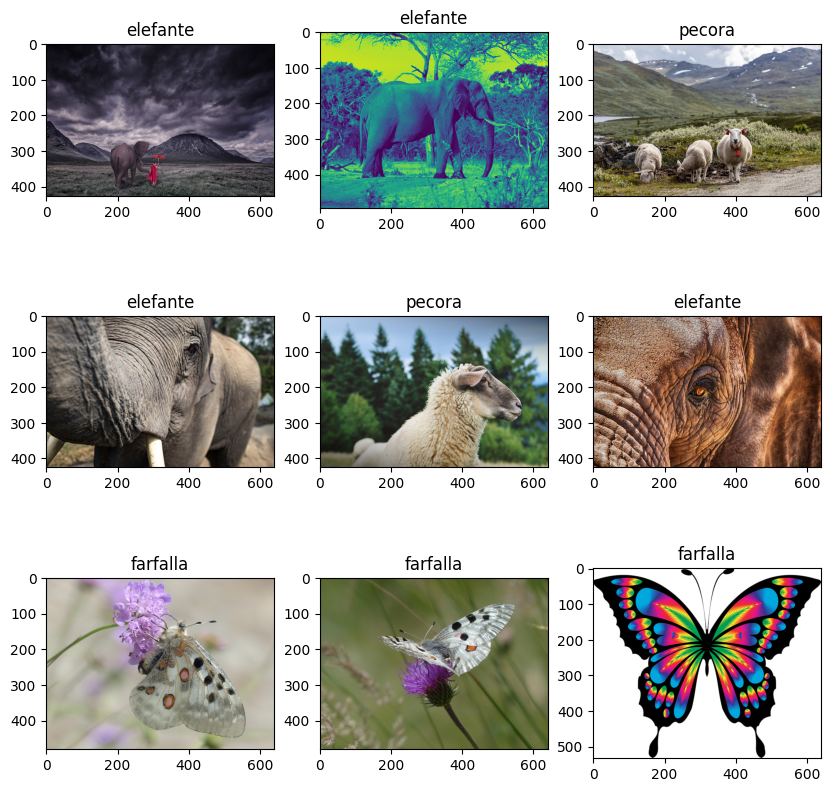

In [56]:
import PIL.Image as Image
plt.figure(figsize=(10, 10))
for i in range(9):
    img_name = test_data.filename[i+200]
    img_path = os.path.join(test_dir, img_name)
    label = test_data.target[i+200]
    ax = plt.subplot(3, 3, i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(label)

Text(0.5, 1.0, 'elefante')

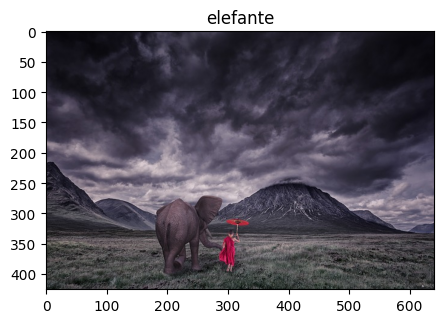

In [57]:
import PIL.Image as Image

# Choose a specific index to target
index_to_display = 200  # Adjust this index to your desired image

plt.figure(figsize=(5, 5))  # Adjust figure size as needed

img_name = test_data.filename[index_to_display]
img_path = os.path.join(test_dir, img_name)
label = test_data.target[index_to_display]

img = Image.open(img_path)
plt.imshow(img)
plt.title(label)